In [1]:
import numpy as np
import h5py
import os
import glob
from utilityFunctions import load_csv_to_matrix, load_csv_to_matrix_batch, compute_color_preference_raw_batch, compute_color_preference_distance_batch, show_heatmaps, compute_color_similarity_distance_batch, compute_correlations, RSA, split_and_average_matrices, perform_mds_and_plot
from utilityFunctions_GWOT import GWD_and_find_best, GWD_and_plot

In [2]:
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)
folder_path = 'raw_data/202411_data'
response_type = 'preference'

In [3]:
def load_clusters_from_mat_v73(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Keys:", list(f.keys()))  # Inspect available variables

        clusters = f['clusters']
        # Assume it's a 2x1 cell array, and each cell points to a dataset
        cluster1_ref = clusters[0][0]
        cluster2_ref = clusters[1][0]

        cluster1 = np.array(f[cluster1_ref]).astype(int).flatten()
        cluster2 = np.array(f[cluster2_ref]).astype(int).flatten()

        return cluster1, cluster2

In [4]:
cluster1, cluster2 = load_clusters_from_mat_v73('raw_data/clusters_preference_raw.mat')
print(cluster1)
print(cluster2)

Keys: ['#refs#', 'clusters', 'participants', 'process_type', 'rating_type']
[ 1 15 12  7 11  5  8 10  4 13 18]
[ 2 19  6  3 16  9 14 17]


In [5]:
cluster_1_matrices = []
for subject_id in cluster1:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    cluster_1_matrices.append(matrix)

cluster_1_matrices_preference_distance = compute_color_preference_distance_batch(cluster_1_matrices, value_range_max = 3.5)

cluster_2_matrices = []
for subject_id in cluster2:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    cluster_2_matrices.append(matrix)

cluster_2_matrices_preference_distance = compute_color_preference_distance_batch(cluster_2_matrices, value_range_max = 3.5)

In [6]:
stacked_1 = np.stack(cluster_1_matrices_preference_distance)  # Shape: (n_subjects, matrix_size, matrix_size)
cluster_1_mean_preference_distance = np.mean(stacked_1, axis=0)

stacked_2 = np.stack(cluster_2_matrices_preference_distance)  
cluster_2_mean_preference_distance = np.mean(stacked_2, axis=0)

In [7]:
### GWOT configuration
n_eps = 15 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

Best epsilon: 0.05647279437943463, Minimum GWD: 0.207


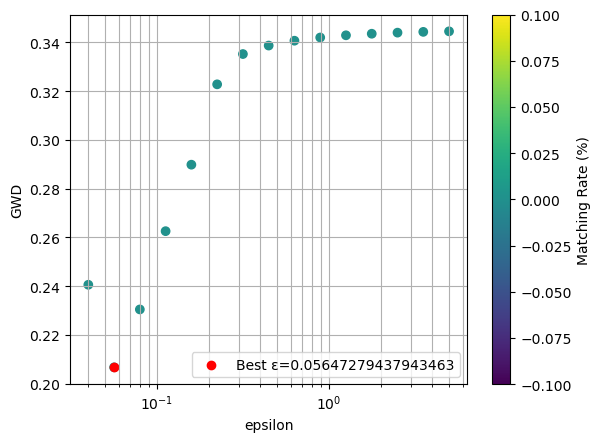

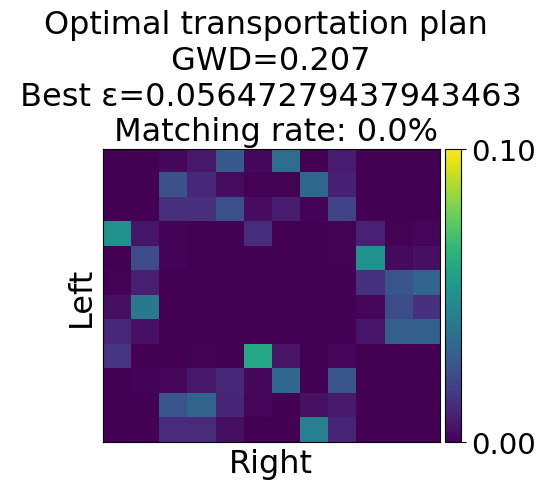

(array([[5.51801815e-06, 4.40308404e-07, 2.10493446e-03, 6.50176690e-03,
         2.86533077e-02, 2.09477430e-03, 3.56717945e-02, 1.33763936e-04,
         8.15695491e-03, 8.02527209e-06, 4.37050540e-07, 1.61598671e-06],
        [4.50254031e-07, 6.67362542e-07, 2.46978289e-02, 1.15565344e-02,
         3.39843797e-03, 7.19561598e-04, 3.93095268e-04, 3.36076828e-02,
         8.80478822e-03, 1.51169198e-04, 5.58804389e-07, 2.55857917e-06],
        [1.06076328e-05, 9.84954534e-06, 1.35206350e-02, 1.35203339e-02,
         2.43097796e-02, 3.14079694e-03, 7.89277363e-03, 1.09753416e-03,
         1.97634680e-02, 5.80217155e-05, 3.58702776e-06, 5.94617118e-06],
        [5.12019424e-02, 5.65376612e-03, 9.16199479e-04, 3.04336618e-04,
         2.12110815e-04, 1.29883745e-02, 2.16414689e-04, 6.39919280e-05,
         7.38410548e-04, 9.03351988e-03, 6.62319193e-04, 1.34194722e-03],
        [3.36439456e-04, 2.33372254e-02, 8.02820550e-04, 1.38159227e-04,
         6.12973475e-06, 6.95721314e-05, 3.4732

In [8]:
GWD_and_plot(cluster_1_mean_preference_distance, cluster_2_mean_preference_distance, epsilons)